# Basic API for qttpdesolver package (2D case).

For illustration, we consider below the following solvers 

- Solver-FS (a new Finite Sum solver)

- Solver-FD (a Finite Difference solver) 

for 2D stationary diffusion type PDE with scalar coefficient.

### First of all, we have to import  the main classes, functions and constants:

- Pde - is a class that represent equation. It collect benchmarks (prepared model PDEs), coefficients and parameters of calculation. The calculation results are also stored (automatically) in the instance of this class.

- create_solver - is a function for construction of the Solver class instance according to selected solver type and calculation mode.

- auto_solve - is a very usefull function that perfom all required steps to solve PDE and prepare results (if it is not used, then special functions like prep_solution, prep_derivative, prep_uu and prep_uf should be called explicitly).

- MODE_NP, MODE_TT, MODE_SP - are the constants that indicate the mode of calculation (numpy or tensor train or scipy sparse respectively). Note: MODE_SP is not available for the SolverFs. 

- SOLVER_FS, SOLVER_FD - are the constants that indicate the solver type.

In [1]:
%matplotlib inline
import numpy as np

from qttpdesolver import Pde, create_solver, auto_solve
from qttpdesolver import MODE_NP, MODE_TT, MODE_SP, SOLVER_FS, SOLVER_FD

### We'll also import some additional functions (only for test perposes):

(this functions are called from auto_solve function automatically)

In [2]:
from qttpdesolver.solve import prep_solution, prep_derivative, prep_uu, prep_uf

### Now we'll construct a PDE:

(model parameters should be set explicitly)

In [3]:
PDE = Pde()
PDE.txt = 'Simple 2D PDE for test' # It will be used in results representation
PDE.dim = 2                        # Dimension of the spatial variable
PDE.L   = 1.                       # Domain size (this variable is not used in current version: L=1 always)
 
# We set functions for coefficient k, rhs
# and analytic solution and derivatives of the model PDE (-1.)*div (k grad u) = f
# (all functions should have the same arguments)

def k_func(x, y, w1, w2):
    return 1. + x*y*y

def f_func(x, y, w1, w2):
    xy = x*y; xy2 = xy*y
    s1 = np.sin(w1*x*x); s2 = np.sin(w2*y)
    c1 = np.cos(w1*x*x); c2 = np.cos(w2*y)
    return (4.*w1*w1*x*x + w2*w2)*(1. +xy2)*s1*s2\
          - 2.*w1*(1. + 2.*xy2)*c1*s2 - 2.*w2*xy*s1*c2

def u_func(x, y, w1, w2):
    return np.sin(w1*x*x)*np.sin(w2*y)

def ux_func(x, y, w1, w2):
    return w1*2.*x*np.cos(w1*x*x)*np.sin(w2*y)

def uy_func(x, y, w1, w2):
    return w2*np.sin(w1*x*x)*np.cos(w2*y)

# And now we set this functions as parameters of PDE class instance
# (txt descriptions will be used for output)

PDE.k_txt = 'k  = 1+x*y^2' 
PDE.k = k_func

PDE.f_txt = 'f  = ... according to exact solution u'
PDE.f = f_func

PDE.u_txt = 'u  = sin(w_1 x^2) sin(w_2 y)'
PDE.u = u_func   # analytical solution

PDE.ux_txt = 'ux = 2 w_1 x cos(w_1 x^2) sin(w_2 y)'
PDE.ux = ux_func # analytical du/dx

PDE.uy_txt = 'uy = w_2 sin(w_1 x^2) cos(w_2 y)'
PDE.uy = uy_func # analytical du/dy

# We also set parameters values and text description
PDE.params_txt = 'w1 [=%-8.4f], w2 [=%-8.4f]'
PDE.set_params([np.pi/PDE.L, np.pi/PDE.L * 2])

# This function present current model
PDE.present_model()

PDE:        Simple 2D PDE for test
Parameters: w1 [=3.1416  ], w2 [=6.2832  ]
k  = 1+x*y^2
f  = ... according to exact solution u
u  = sin(w_1 x^2) sin(w_2 y)
ux = 2 w_1 x cos(w_1 x^2) sin(w_2 y)
uy = w_2 sin(w_1 x^2) cos(w_2 y)



### Compact form

The code from the previous cell may be rewritten in a more compact form if we use a model from gallery:

In [4]:
PDE = Pde()
PDE.present_models()
print '-'*50
PDE.set_model('Simple. Analyt 2D diffusion PDE') # number (1) or name of the model may be used
PDE.set_params([np.pi, np.pi*2])                 # default values of parameters can be changed
PDE.present_model()

The following models are available:
Model # 0. Name: |Simple. Analyt 1D diffusion PDE|
   -div(k grad u) = f in [0, 1]; u_d = 0; u is known
Model # 1. Name: |Simple. Analyt 2D diffusion PDE|
   -div(k grad u) = f in [0, 1]^2; u_d = 0; u is known
Model # 2. Name: |Simple. Analyt 3D diffusion PDE|
   -div(k grad u) = f in [0, 1]^3; u_d = 0; u is known
Model # 3. Name: |Simple. Msc 1D diffusion PDE|
   -div(k grad u) = f in [0, 1]; u_d = 0; k - 1d multiscale coeff.
Model # 4. Name: |Simple. Msc 2D diffusion PDE|
   -div(k grad u) = f in [0, 1]^2; u_d = 0; k - 2d multiscale coeff.
Model # 5. Name: |Simple. Msc 3D diffusion PDE|
   -div(k grad u) = f in [0, 1]^3; u_d = 0; k - 3d multiscale coeff.
Model # 6. Name: |Simple. 1D diffusion PDE with rhs=1|
   -div(k grad u) = f in [0, 1]; u_d = 0; f=1
Model # 7. Name: |Simple. 2D diffusion PDE with rhs=1|
   -div(k grad u) = f in [0, 1]^2; u_d = 0; f=1
Model # 8. Name: |Simple. 3D diffusion PDE with rhs=1|
   -div(k grad u) = f in [0, 1]^3; u_d =

### Next, we have to set parameters of the calculation:

In [5]:
PDE.set_mode(MODE_TT)            # Calculation mode ('np': numpy, 'tt':tensor train or 'sp': scipy sparse)
                                 # (Note: MODE_SP is not available for Solver-FS)
PDE.set_solver_txt(SOLVER_FS)    # Name of the solver (SOLVER_FS='fs' or SOLVER_FD='fd')
                                 # (if auto_solve is used then solver will be selected from this var.
PDE.set_verb(verb_gen=True,      # If is True then general info will be printed
             verb_crs=False,     # If is True then cross approximation info will be printed
             verb_lss=False)     # If is True then lin. syst. solver info will be printed
PDE.set_tau(tau=1.E-10,          # Accuracy for tt-representation
            eps_lss=1.E-10,      # Accuracy for linear system solver iterations, 
            tau_lss=1.E-10)      # Accuracy for linear system solver resulting rounding
                                 # (if tau_lss is None, then real accurace of solver will be used)
                                 # There is one more parameter tau_real (=tau*1.E-2 by default),
                                 # that is the accuracy for construction of analytical solution
PDE.set_lss_params(nswp=20,      # Settings for linear system solver
                   kickrank=4, 
                   local_prec='n', 
                   local_iters=2,
                   local_restart=20, 
                   trunc_norm=1, 
                   max_full_size=100)
PDE.present_info()               # This function prints current settings

__________________General parameters
Mode          : tt
Solver        : fs
Model num     : 1 
Parameters    : w1 [=3.1416  ], w2 [=6.2832  ]
__________________Verbosity parameters
verb_gen      : True
verb_crs      : False
verb_lss      : False
print_to_std  : True
print_to_file : False
__________________TT parameters
tau           : 1.00e-10
eps_lss       : 1.00e-10
tau_lss       : 1.00e-10
tau_real      : 1.00e-12
lss: nswp     : 20  
lss: kickrank : 4   
lss: use sol0 : False



### PDE solution:

In [6]:
# We set value of d. This function also recalculates
# n=2**d (a number of grid nodes along one axis) and h=L/n (grid step) (L=1).
PDE.update_d(6)

# We remove results of the previous calculations (it's necessary only for the case
# then the same PDE instance is used for several calculations):
PDE.clean()

# We create solver class instance and explicitly call 4 main functions:
PDESolver = create_solver(PDE)
PDESolver.gen_coefficients()
PDESolver.gen_matrices()
PDESolver.gen_system()
PDESolver.gen_solution()
# We can call only one function instead gen_* functions:
#PDESolver.solve() 

# This functions calculate errors, eranks, derivatives and so on:
prep_solution(PDE)
prep_derivative(PDE)
prep_uu(PDE)
prep_uf(PDE, PDESolver)
    
# This function presents result in a one string mode:
PDE.present_res_1s()

Time of coeffs.  generation: 0.4630  
Time of matrices generation: 0.3032  
Time of system generation  : 0.0752  
Time of system solving     : 0.6243  
d= 6|fs-tt|er=6.8e-04 |erdx=4.9e-04 |erdy=2.8e-04 |T=1.466  |R=6.9  |It=3 


### Compact form:

The code from the previous cell may be rewritten in a more compact form if we use an auto_solve function:

In [7]:
PDE.update_d(6)
PDE.set_verb(verb_gen=True, verb_crs=False, verb_lss=True) 
PDESolver = auto_solve(PDE, return_solver=True)

Time of coeffs.  generation: 0.4256  
Time of matrices generation: 0.2261  
Time of system generation  : 0.1198  
amen_solve: swp=1, max_dx= 9.531E-01, max_res= 9.238E-01, max_rank=16
amen_solve: swp=2, max_dx= 2.939E-08, max_res= 1.806E-09, max_rank=19
amen_solve: swp=3, max_dx= 2.892E-10, max_res= 3.043E-11, max_rank=20
Time of system solving     : 0.5934  
Time of additional calcs.  : 0.2949  
d= 6|fs-tt|er=6.8e-04 |erdx=4.9e-04 |erdy=2.8e-04 |T=1.365  |R=6.9  |It=3 


### The output in the 1-string mode has the following sense:
- d=6 - is a factor of grid size (n=2^d),
- fs-tt - is a name of the used solver and a calculation mode,
- er=6.8e-04 - is the error of solution vs analytical (if it's known),
- erdx=4.9e-04 - is the error of x-derivative vs analytical (if it's known),
- erdy=2.8e-04 - is the error of y-derivative vs analytical (if it's known),
- T=1.268 - is the time of calculation in seconds (an exact numerical values may depend on work station, which is used for computations),
- R=6.9 - is the e-rank of the calculated solution (since random restart in AMEn-solver is used, the rank can vary within a small range),
- It=3 - is a number of AMEn iterations,

### Then we can present the calculation results:

PDE                : -div(k grad u) = f in [0, 1]^2; u_d = 0; u is known
PDE mode           : tt
Used PDE solver    : fs
PDE dimension      : 2   
Value of d         : 6   
Mesh 1D size       : 64  
Solution erank     : 6.91  
Analit. sol. erank : 2.95  
Solution error     : 6.77e-04
X-derivative error : 4.91e-04
Y-derivative error : 2.82e-04
(u, f) real        : 13.1127663016   
(u, f) calc        : 13.1217286084   
(u, f) err         : 6.83e-04
Solver iterations  : 3   
Matrix A erank     : 30  
Vector rhs erank   : 7   
Time: coeff.   (s.): 0.4256  
Time: matrices (s.): 0.2261  
Time: system   (s.): 0.1198  
Time: system   (s.): 0.5934  
Total time     (s.): 1.3649  
*Time: prep.   (s.): 0.2949  



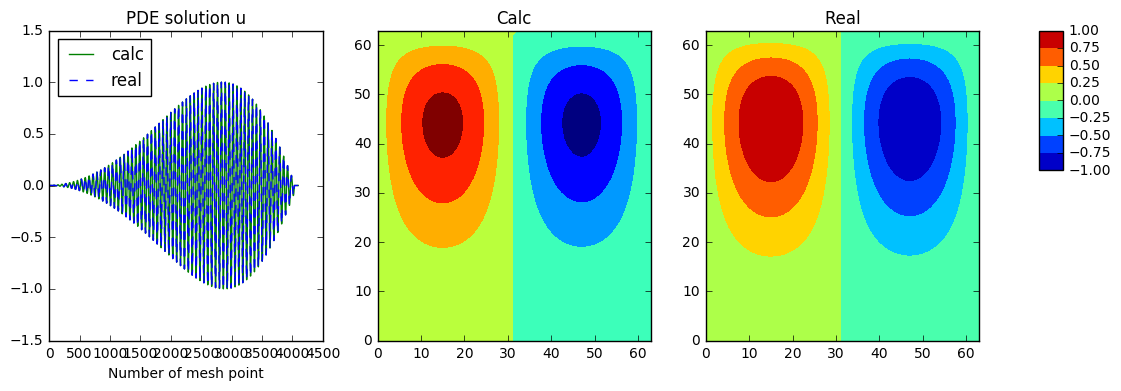

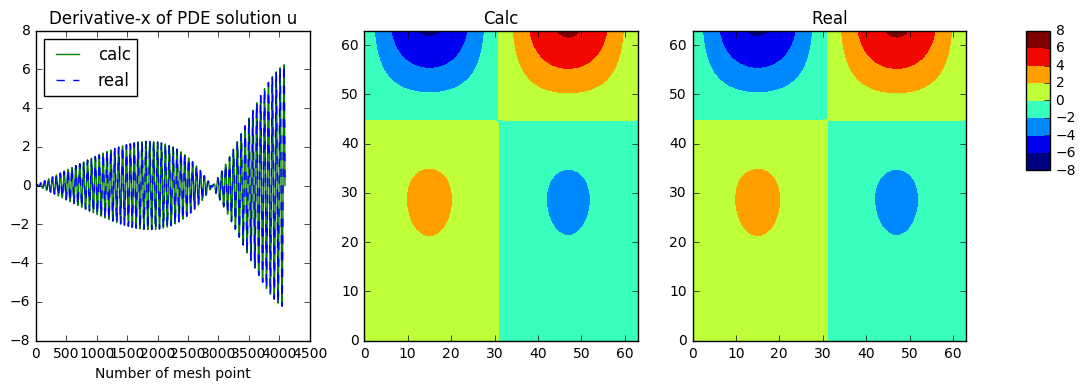

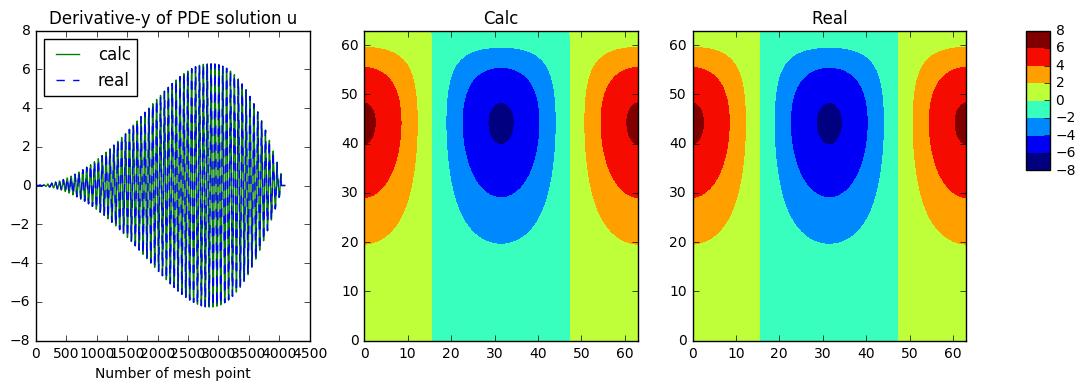

In [8]:
PDE.present_res()
PDE.plot_res()

### The following variables and values are saved in Pde class instance after calculation (some of them may be None):

- Linear system solver parameters (iters and so on) (for MODE_TT)
- Effective ranks of the main vectors and matrices: r['A'], r['rhs'], ... (for MODE_TT)
- Calculated solution: u_calc, u_calc_ranks (for MODE_TT)
- Analytical solution: u_real, u_real_ranks (for MODE_TT)  and the error u_err
- Calculated derivatives: ux_calc, uy_calc
- Analytical derivatives: ux_real, uy_real and the errors ux_err, uy_err
- Functional (u, u): uu_calc, uu_real, uu_err
- Functional (u, f): uf_calc, uf_real, uf_err
- Times of the main operations (t['cgen'], ...) and t_full

In [9]:
print PDE.u_calc
print PDE.u_real
print PDE.ux_calc
print PDE.ux_real
print PDE.uy_calc
print PDE.uy_real
print PDE.uu_calc

 tt-vector |u_calc|             [tau=1.00e-10] {d=12} (erank=  6.9)
 tt-vector |u_real|             [tau=1.00e-10] {d=12} (erank=  3.0)
 tt-vector |ux_calc|            [tau=1.00e-10] {d=12} (erank=  9.5)
 tt-vector |ux_real|            [tau=1.00e-10] {d=12} (erank=  3.0)
 tt-vector |uy_calc|            [tau=1.00e-10] {d=12} (erank=  8.8)
 tt-vector |uy_real|            [tau=1.00e-10] {d=12} (erank=  3.0)
0.189221523929


### The following variables are saved in PDESolver class instance (for Solver_FS) after calculation:

In [10]:
print PDESolver.f
print PDESolver.iKx
print PDESolver.iKy
print PDESolver.Bx
print PDESolver.By
print PDESolver.iqx
print PDESolver.iqy
print PDESolver.qx
print PDESolver.qy
print PDESolver.Wx
print PDESolver.Wy
print PDESolver.Rx
print PDESolver.Ry
print PDESolver.Hx
print PDESolver.Hy
print PDESolver.A
print PDESolver.rhs
print PDESolver.wx

 tt-vector |f|                  [tau=1.00e-10] {d=12} (erank=  5.4)
 tt-matrix |iKx|                [tau=1.00e-10] {d=12} (erank=  7.0)
 tt-matrix |iKy|                [tau=1.00e-10] {d=12} (erank=  7.0)
 tt-matrix |Bx|                 [tau=1.00e-10] {d=12} (erank=  1.5)
 tt-matrix |By|                 [tau=1.00e-10] {d=12} (erank=  1.5)
 tt-vector |iqx|                [tau=1.00e-10] {d= 6} (erank=  3.6)
 tt-vector |iqy|                [tau=1.00e-10] {d= 6} (erank=  3.4)
 tt-vector |qx|                 [tau=1.00e-10] {d= 6} (erank=  3.6)
 tt-vector |qy|                 [tau=1.00e-10] {d= 6} (erank=  3.4)
 tt-matrix |Wx|                 [tau=1.00e-10] {d=12} (erank=  2.5)
 tt-matrix |Wy|                 [tau=1.00e-10] {d=12} (erank=  2.3)
 tt-matrix |Rx|                 [tau=1.00e-10] {d=12} (erank= 14.7)
 tt-matrix |Ry|                 [tau=1.00e-10] {d=12} (erank= 23.7)
 tt-matrix |Hx|                 [tau=1.00e-10] {d=12} (erank= 15.3)
 tt-matrix |Hy|                 [tau=1.00e-10] {

### Note that all variables have type Vector or Matrix from subpackage tensor_wrapper.

This is format-free representation of arrays (operations in MODE_NP, MODE_TT and MODE_SP have the same form in this format). 

If one needs numpy array, then to_np property should be called (it works only for moderate d values).

Property to_tt converts Vector or Matrix class instance to tt-format. 

Otherwise the .x property may be used - it contains the np.ndarray or tt.vector or tt.matrix or scipy.sparse scr matrix.

In [11]:
print type(PDESolver.A)
A_tt = PDESolver.A.to_tt
print type(A_tt)
A_np = PDESolver.A.to_np
print type(A_np)
print A_np.shape
print type(PDESolver.A.x)

<class 'qttpdesolver.tensor_wrapper.matrix.Matrix'>
<class 'tt.core.matrix.matrix'>
<type 'numpy.ndarray'>
(4096, 4096)
<class 'tt.core.matrix.matrix'>


### And now let perform the same calculation for Solver-FD in MODE_TT in a compact form

In [1]:
%matplotlib inline
import numpy as np

from qttpdesolver import Pde, auto_solve
from qttpdesolver import MODE_NP, MODE_TT, MODE_SP, SOLVER_FS, SOLVER_FD

In [2]:
PDE = Pde()

PDE.set_model('Simple. Analyt 2D diffusion PDE')
PDE.set_params([np.pi, np.pi*2])
PDE.set_mode(MODE_TT)
PDE.set_solver_txt(SOLVER_FD)
PDE.set_verb(True, True, True)
PDE.set_tau(tau=1.E-10, eps_lss=1.E-10, tau_lss=1.E-10)
PDE.set_lss_params(nswp=20, kickrank=4, local_prec='n', local_iters=2,
                   local_restart=20, trunc_norm=1, max_full_size=100)
PDE.update_d(6)
PDESolver = auto_solve(PDE, return_solver=True)

  Construction of Kx
=multifuncrs= sweep 1{2}, max_dy: 4.842e-01, erank: 5.38516
=multifuncrs= sweep 2{1}, max_dy: 5.613e-16, erank: 6.16441
  Construction of Ky
=multifuncrs= sweep 1{2}, max_dy: 4.811e-01, erank: 5.38516
=multifuncrs= sweep 2{1}, max_dy: 7.940e-16, erank: 6.16441
  Construction of f
=multifuncrs= sweep 1{2}, max_dy: 1.758e+00, erank: 5.38516
=multifuncrs= sweep 2{1}, max_dy: 2.643e-07, erank: 8.18535
=multifuncrs= sweep 2{2}, max_dy: 2.643e-07, erank: 8.544
=multifuncrs= sweep 3{1}, max_dy: 1.457e-11, erank: 8.3666
Time of coeffs.  generation: 0.3218  
Time of matrices generation: 0.0081  
Time of system generation  : 0.0194  
amen_solve: swp=1, max_dx= 9.668E+01, max_res= 1.961E+02, max_rank=11
amen_solve: swp=2, max_dx= 4.216E-05, max_res= 2.490E-03, max_rank=15
amen_solve: swp=3, max_dx= 1.075E-07, max_res= 7.871E-07, max_rank=19
amen_solve: swp=4, max_dx= 8.553E-09, max_res= 3.659E-08, max_rank=21
amen_solve: swp=5, max_dx= 2.865E-10, max_res= 8.627E-10, max_rank=

PDE                : -div(k grad u) = f in [0, 1]^2; u_d = 0; u is known
PDE mode           : tt
Used PDE solver    : fd
PDE dimension      : 2   
Value of d         : 6   
Mesh 1D size       : 64  
Solution erank     : 6.78  
Analit. sol. erank : 2.95  
Solution error     : 6.77e-04
X-derivative error : 4.91e-04
Y-derivative error : 2.82e-04
(u, f) real        : 13.1127663016   
(u, f) calc        : 13.1217286083   
(u, f) err         : 6.83e-04
Solver iterations  : 6   
Matrix A erank     : 7   
Vector rhs erank   : 5   
Time: coeff.   (s.): 0.3218  
Time: matrices (s.): 0.0081  
Time: system   (s.): 0.0194  
Time: system   (s.): 0.2023  
Total time     (s.): 0.5517  
*Time: prep.   (s.): 0.3884  



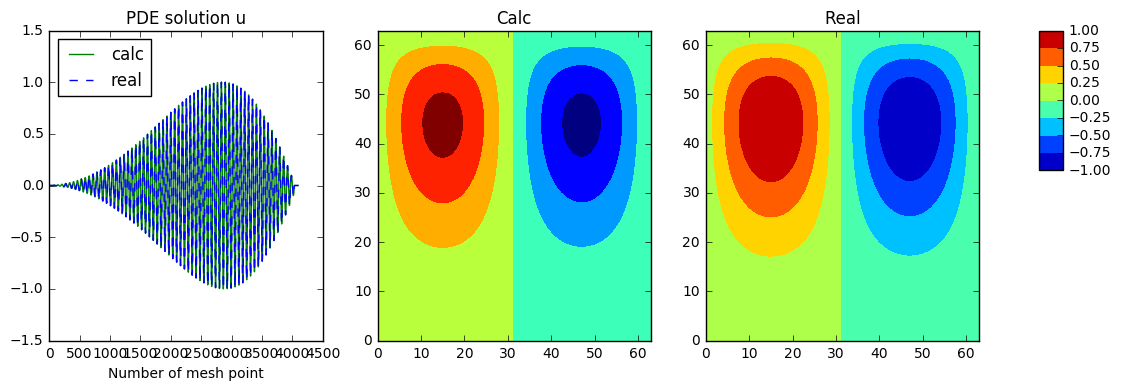

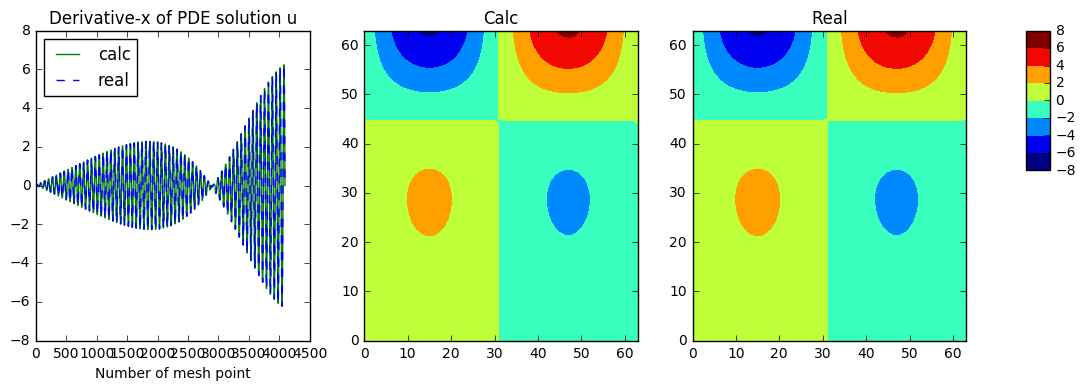

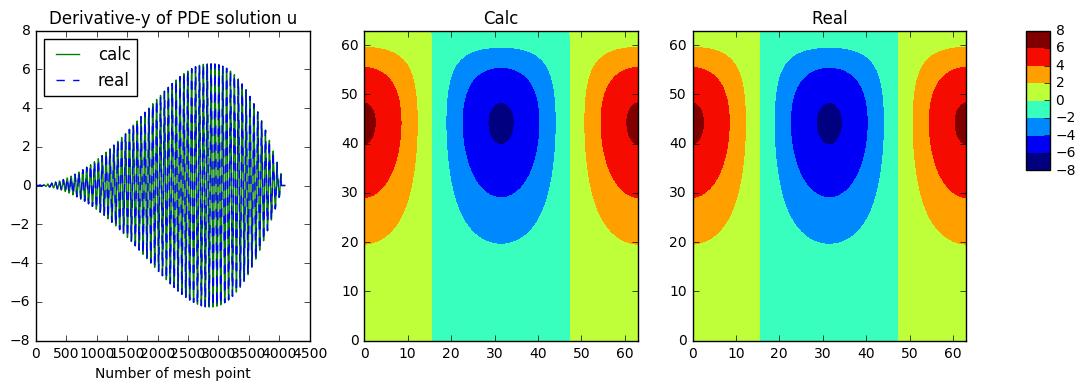

In [3]:
PDE.present_res()
PDE.plot_res()